# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import ast # for literal_eval

import warnings
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [ ]:
# Load in the general demographics data.
azdias_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_df.shape

(891221, 85)

In [ ]:
azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [ ]:
feat_summary.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
azdias_df.isna().sum()

,0
AGER_TYP,0
ALTERSKATEGORIE_GROB,0
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [ ]:
# Identify missing or unknown data values and convert them to NaNs.

# used for reference:
# https://www.geeksforgeeks.org/python/difference-between-eval-and-ast-literal-eval-in-python/

# make a copy to modify data
azdias_cleaned_df = azdias_df.copy()

for index, row in feat_summary.iterrows():
    attribute = row['attribute']
    missing_values_str = row['missing_or_unknown']

    # convert the string representation of list to a list
    try:
        missing_values_list = ast.literal_eval(missing_values_str)
    except (ValueError):
        print(attribute, missing_values_str)
        # 3 attributes have strings('X', 'XX'), non int values in list
        # and are not handled by literal_eval,
        # those are handled in the next code cell

        # empty missing values list, nothing will be replaced in this cell
        # for those 3 attributes
        missing_values_list = []


    if attribute in azdias_cleaned_df.columns and missing_values_list:
        # replace identified missing values with NaN
        azdias_cleaned_df[attribute] = azdias_cleaned_df[attribute].replace(missing_values_list, np.nan)



CAMEO_DEUG_2015 [-1,X]
CAMEO_DEU_2015 [XX]
CAMEO_INTL_2015 [-1,XX]


In [ ]:
# 3 attributes that had parsing issues

x_columns = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

for column in x_columns:
    # replace 'X' and 'XX' with NaN
    azdias_cleaned_df[column] = azdias_cleaned_df[column].replace({'X': np.nan, 'XX': np.nan})
    # also need to replace -1 values with NaN
    if -1 in azdias_cleaned_df[column].unique():
          azdias_cleaned_df[column] = azdias_cleaned_df[column].replace({-1: np.nan})

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

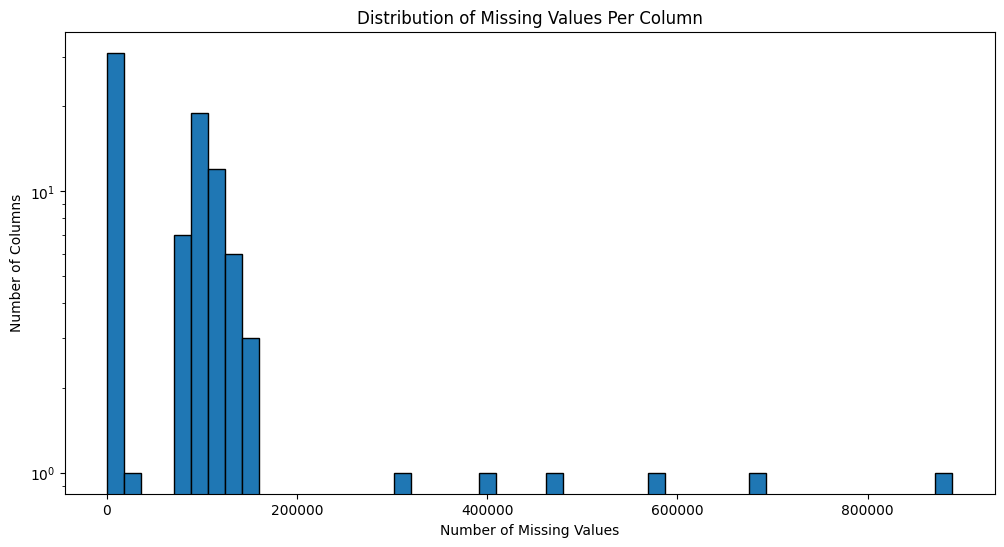

In [ ]:
# Perform an assessment of how much missing data there is in each column of the dataset
missing_counts = azdias_cleaned_df.isnull().sum()

# histogram of the missing value counts per column
plt.figure(figsize=(12, 6))
plt.hist(missing_counts, bins=50, edgecolor='black')
plt.title('Distribution of Missing Values Per Column')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.yscale('log')
plt.show()

In [ ]:
# Investigate patterns in the amount of missing data in each column.

# looking at the histogram, the outliers all seem to be above 200000
cutoff = 200000

# get columns to drop based on the cutoff
columns_to_drop = missing_counts[missing_counts > cutoff].index.tolist()

print(f'Columns to be dropped:\n{columns_to_drop}')

Columns to be dropped:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [ ]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# drop the identified columns from the dataframe
azdias_cleaned_df.drop(columns=columns_to_drop, inplace=True)

print('Shape of DataFrame after dropping high-missing-value columns:', azdias_cleaned_df.shape)

Shape of DataFrame after dropping high-missing-value columns: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

Most columns in the azdias_df DataFrame had a relatively low number of missing values, but a few columns stood out with significantly higher counts. Based on the histogram of missing value counts, a cutoff point of 200,000 missing values was identified to distinguish outliers. Columns exceeding this threshold were considered to have too much missing data to be useful for the analysis and were removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

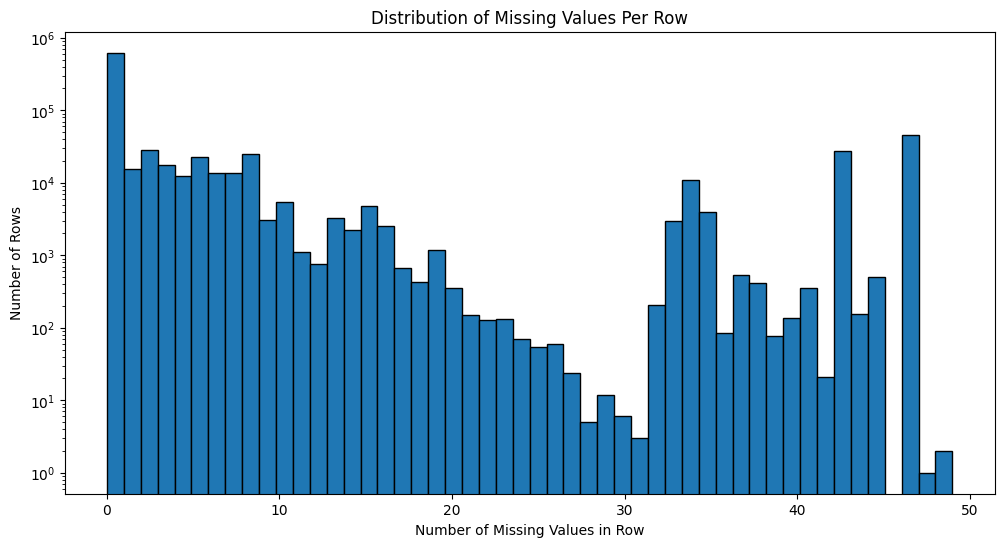

In [ ]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_cleaned_df.isnull().sum(axis=1)

# plot a histogram of the missing values per row
plt.figure(figsize=(12, 6))
plt.hist(missing_rows, bins=50, edgecolor='black')
plt.title('Distribution of Missing Values Per Row')
plt.xlabel('Number of Missing Values in Row')
plt.ylabel('Number of Rows')
plt.yscale('log')
plt.show()

In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# cutoff for missing values per row.
missing_value_cutoff = 5

# series with the count of missing values per row
missing_rows_count = azdias_cleaned_df.isnull().sum(axis=1)

# two subsets
low_missing_df = azdias_cleaned_df[missing_rows_count <= missing_value_cutoff].copy()
high_missing_df = azdias_cleaned_df[missing_rows_count > missing_value_cutoff].copy()

print(f'Shape of DataFrame with low missing values (<= {missing_value_cutoff}): {low_missing_df.shape}')
print(f'Shape of DataFrame with high missing values (> {missing_value_cutoff}): {high_missing_df.shape}')

Shape of DataFrame with low missing values (<= 5): (719624, 79)
Shape of DataFrame with high missing values (> 5): (171597, 79)


Columns with less than 1% missing values: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PL

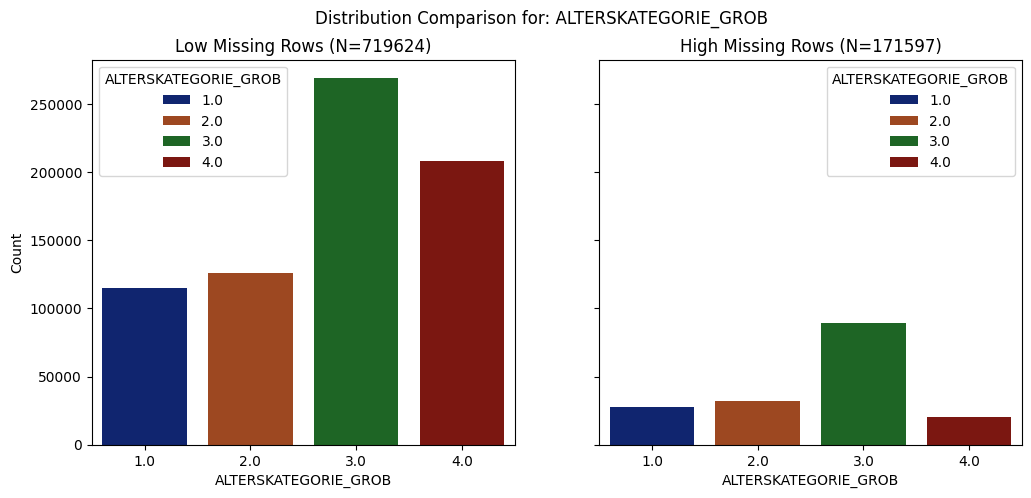

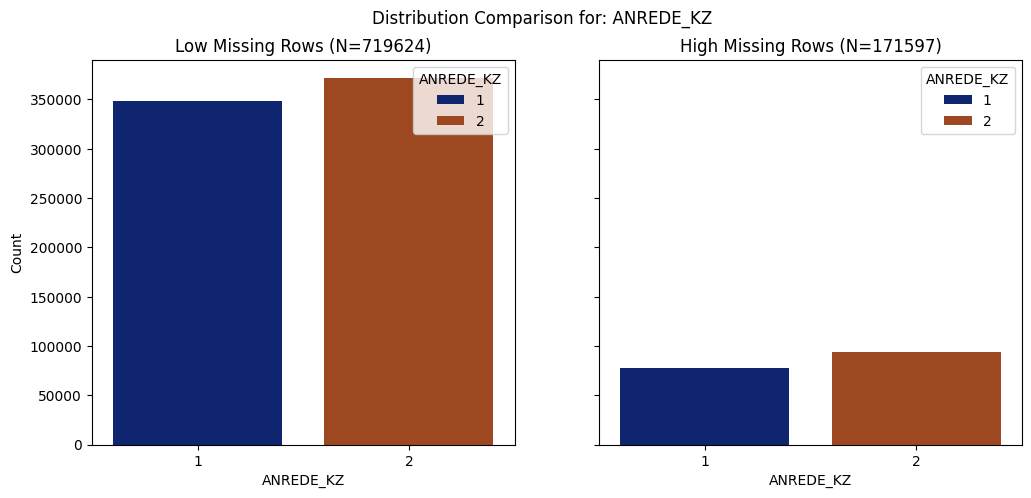

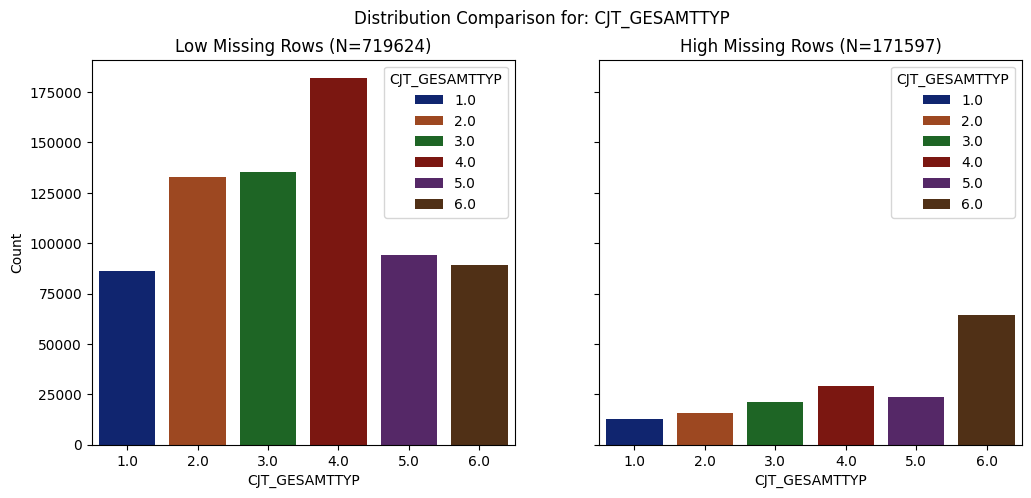

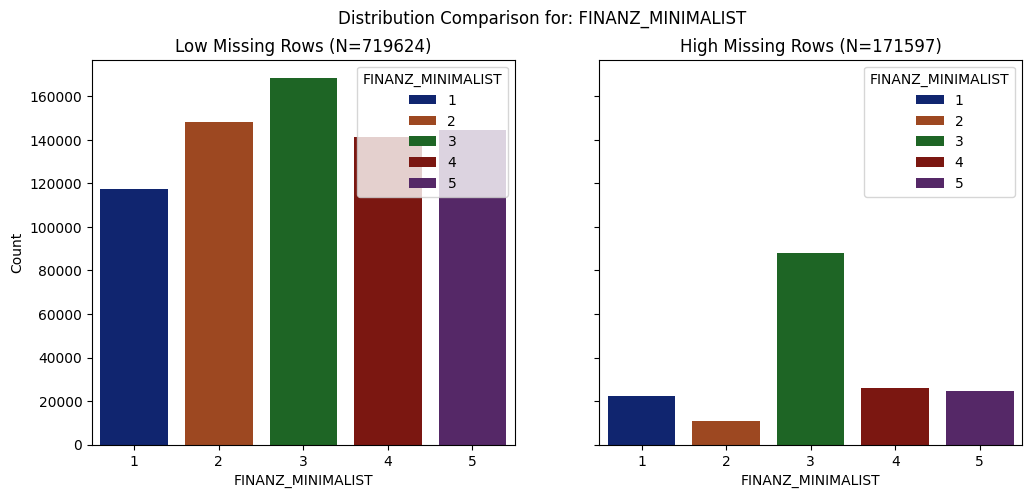

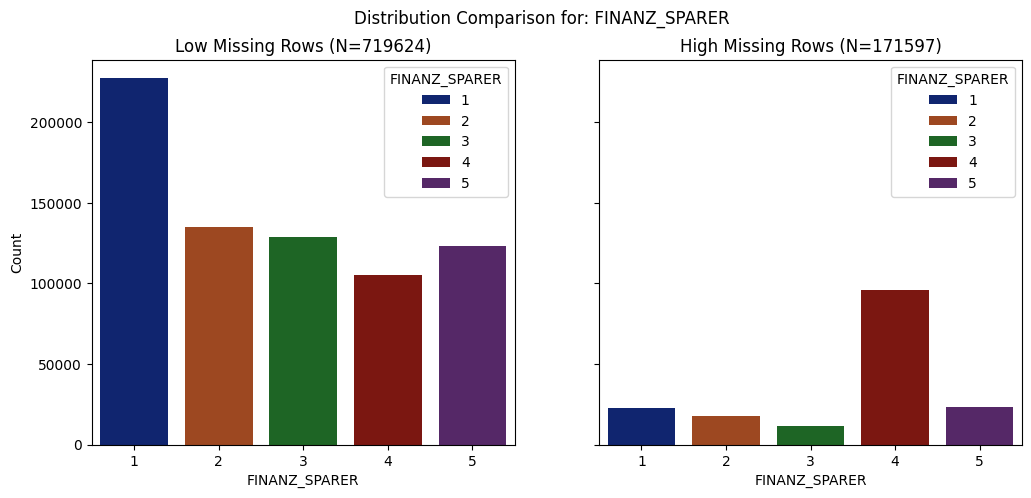

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# get columns with less than 1% missing values
columns_with_few_missing = low_missing_df.isnull().sum()
columns_with_few_missing = columns_with_few_missing[columns_with_few_missing < len(low_missing_df) * 0.01].index.tolist()
print(f'Columns with less than 1% missing values: {columns_with_few_missing}\n')

def compare_plots(column_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Distribution Comparison for: {column_name}')

    sns.countplot(data=low_missing_df, x=column_name, ax=ax1,
                  hue=column_name, palette='dark')
    ax1.set_title(f'Low Missing Rows (N={len(low_missing_df)})')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Count')

    sns.countplot(data=high_missing_df, x=column_name, ax=ax2,
                  hue=column_name, palette='dark')
    ax2.set_title(f'High Missing Rows (N={len(high_missing_df)})')
    ax2.set_xlabel(column_name)
    ax2.set_ylabel('Count')

    plt.show()

for column in columns_with_few_missing[:5]:
    compare_plots(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row

A histogram of missing values per row revealed a significant concentration of rows with very few missing values, but also a substantial number of rows with a higher count of missing entries. To investigate this further, the data was divided into two subsets using a threshold of 5 missing values per row. The low_missing_df contained rows with 5 or fewer missing values (719,624 rows), while the high_missing_df contained rows with more than 5 missing values (171,597 rows).

When comparing the distributions of several selected features (ALTERSKATEGORIE_GROB, ANREDE_KZ, CJT_GESAMTTYP, FINANZ_MINIMALIST, FINANZ_SPARER) between these two subsets, it was evident from viewing the plots that they are qualitatively different. The distributions of values for these features varied considerably between the low-missing and high-missing groups. This suggests that the rows with a high number of missing values are not representative of the general population.  For this reason, the subset of data with low or no missing values (low_missing_df) will be used moving forward.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?
feat_summary['type'].value_counts()

,count
type,
ordinal,49
categorical,21
numeric,7
mixed,7
interval,1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# categorical features from feat_summary
categorical_features = feat_summary[feat_summary['type'] == 'categorical']['attribute'].tolist()

binary_categorical_features = []
multi_level_categorical_features = []

for col in categorical_features:
    if col in low_missing_df.columns:
        num_unique_values = low_missing_df[col].nunique()
        print(col, low_missing_df[col].unique())

        if num_unique_values == 2:
            binary_categorical_features.append(col)
        elif num_unique_values > 2:
            multi_level_categorical_features.append(col)

print(f'\nBinary Categorical Features ({len(binary_categorical_features)}):\n{binary_categorical_features}\n')
print(f'Multi-level Categorical Features ({len(multi_level_categorical_features)}):\n{multi_level_categorical_features}\n')

ANREDE_KZ [2 1]
CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [10.  5.  1. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 5.  1. 10.  2. nan  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1.  5.  2. nan  4.]
LP_STATUS_FEIN [ 2.  3.  4.  1. 10.  8.  9.  5.  6.  7.]
LP_STATUS_GROB [1. 2. 5. 4. 3.]
NATIONALITAET_KZ [ 1.  2. nan  3.]
SHOPPER_TYP [ 3.  2.  0.  1. nan]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [8. 1. 3. 6. 2. 4. 5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '3' '7' nan]
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '5C' '9B' '2A'
 '1B' '8B' '3D' '7A' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']

Binary Categorical Features (5):
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-level Categorical Features (13):
['CJ

#### From Data_Dictionary.md file

##### 3.6. OST_WEST_KZ
##### Building location via former East / West Germany (GDR / FRG)

- -1: unknown
- O: East (GDR)
- W: West (FRG)

In [ ]:
# encode 'OST_WEST_KZ' to numeric values
# 'W' -> 0, 'O' -> 1
# NaN values will remain as NaN

low_missing_df['OST_WEST_KZ'] = low_missing_df['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

print('Unique values for OST_WEST_KZ after re-encoding:', low_missing_df['OST_WEST_KZ'].unique())

Unique values for OST_WEST_KZ after re-encoding: [0 1]


In [ ]:
# Drop multi-level categorical features

# Identify the columns to drop from low_missing_df that are multi-level categorical.
columns_to_drop_multi_level_cat = [col for col in multi_level_categorical_features if col in low_missing_df.columns]

low_missing_df.drop(columns=columns_to_drop_multi_level_cat, inplace=True)

print(f'Dropped multi-level categorical features: {columns_to_drop_multi_level_cat}\n')
print('Shape of DataFrame after dropping multi-level categorical features:', low_missing_df.shape)

Dropped multi-level categorical features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Shape of DataFrame after dropping multi-level categorical features: (719624, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

Section 1.2.1 investigated the categorical features present in the dataset.  The features were categorized into binary and multi-level types. The binary categorical features found were: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, and OST_WEST_KZ. The OST_WEST_KZ feature, which originally had non-numeric values ('W' and 'O'), was re-encoded into numeric values (0 and 1). The other binary features already had numeric representations and were kept as is.

For multi-level categorical features, which included CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, and CAMEO_DEU_2015, the decision was made to drop them from the analysis. This choice was primarily to keep the analysis straightforward and avoid the complexity introduced by one-hot encoding a large number of categories, which could significantly increase the dimensionality of the dataset.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### From Data_Dictionary.md:

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
               7: 60, 8: 70, 9: 70, 10: 80, 11: 80,
               12: 80, 13: 80, 14: 90, 15: 90}

low_missing_df['PRAEGENDE_JUGENDJAHRE_DECADE'] = low_missing_df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)

movement_dict = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
                 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}

low_missing_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = low_missing_df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

print(low_missing_df[['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head())

# drop the original 'PRAEGENDE_JUGENDJAHRE' column
low_missing_df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

print('\nShape of DataFrame after dropping PRAEGENDE_JUGENDJAHRE:', low_missing_df.shape)

   PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOVEMENT
1                          90.0                             0.0
2                          90.0                             1.0
4                          70.0                             0.0
5                          50.0                             0.0
6                          80.0                             0.0

Shape of DataFrame after dropping PRAEGENDE_JUGENDJAHRE: (719624, 67)


### From Data_Dictionary.md

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# convert 'CAMEO_INTL_2015' to numeric, coercing non-numeric values to NaN
low_missing_df['CAMEO_INTL_2015'] = pd.to_numeric(low_missing_df['CAMEO_INTL_2015'], errors='coerce')

# create CAMEO_INTL_2015_WEALTH by extracting the tens place digit
low_missing_df['CAMEO_INTL_2015_WEALTH'] = (low_missing_df['CAMEO_INTL_2015'] // 10).astype('Int64')

# create CAMEO_INTL_2015_LIFESTAGE by extracting the ones place digit
low_missing_df['CAMEO_INTL_2015_LIFESTAGE'] = (low_missing_df['CAMEO_INTL_2015'] % 10).astype('Int64')

# drop the original 'CAMEO_INTL_2015' column
low_missing_df.drop(columns=['CAMEO_INTL_2015'], inplace=True)

print('First 5 rows of engineered features:\n')
print(low_missing_df[['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE']].head())
print(f'\nShape of DataFrame after engineering and dropping CAMEO_INTL_2015: {low_missing_df.shape}')


First 5 rows of engineered features:

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFESTAGE
1                       5                          1
2                       2                          4
4                       4                          3
5                       5                          4
6                       2                          2

Shape of DataFrame after engineering and dropping CAMEO_INTL_2015: (719624, 68)


#### Discussion 1.2.2: Engineer Mixed-Type Features

Section 1.2.2 focused on engineering the two mixed-type features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'.

For 'PRAEGENDE_JUGENDJAHRE', which contained information on generation by decade and movement (mainstream vs. avantgarde), two new features were created:

- 'PRAEGENDE_JUGENDJAHRE_DECADE': A variable representing the decade.

- 'PRAEGENDE_JUGENDJAHRE_MOVEMENT': A binary variable indicating mainstream (0) or avantgarde (1) movement.

The original 'PRAEGENDE_JUGENDJAHRE' column was dropped to avoid redundancy and ensure only the engineered features are used.


For 'CAMEO_INTL_2015', which combined wealth and life stage information, two new features were created:

- 'CAMEO_INTL_2015_WEALTH': Derived from the 'tens'-place digit, representing the wealth type.

- 'CAMEO_INTL_2015_LIFESTAGE': Derived from the 'ones'-place digit, representing the life stage type.

The original 'CAMEO_INTL_2015' column was dropped after these new features were created.

Other mixed-type features were not explicitly engineered or dropped in this step.  The instructions specifically highlighted these two for detailed handling.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # a copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()

    # Put in code here to execute all main cleaning steps:

    # convert missing value codes into NaNs
    for index, row in feat_summary.iterrows():
        attribute = row['attribute']
        missing_values_str = row['missing_or_unknown']

        if attribute in df_cleaned.columns:
            try:
                missing_values_list = ast.literal_eval(missing_values_str)
            except (ValueError):
                # handle cases where literal_eval fails (e.g., 'X', 'XX')
                # these were handled specifically for CAMEO columns earlier
                missing_values_list = []

            if missing_values_list:
                df_cleaned[attribute] = df_cleaned[attribute].replace(missing_values_list, np.nan)

    # handling for 'X' and 'XX' values in CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015
    # columns might have -1, X, or XX as missing codes
    x_cols = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

    for col in x_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].replace({'X': np.nan, 'XX': np.nan})
            # also replace -1 if it's still present in CAMEO_INTL_2015 after literal_eval
            if col == 'CAMEO_INTL_2015' and -1 in df_cleaned[col].unique():
                df_cleaned[col] = df_cleaned[col].replace({-1: np.nan})


    # remove selected columns and rows

    # drop columns with more than 200,000 missing values (identified from azdias_df)
    columns_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns], inplace=True)

    # remove rows with more than 10 missing values
    missing_value_cutoff = 10
    missing_rows_count = df_cleaned.isnull().sum(axis=1)
    df_cleaned = df_cleaned[missing_rows_count <= missing_value_cutoff].copy()

    # select, re-encode, and engineer column values.

    # re-encode 'OST_WEST_KZ'
    if 'OST_WEST_KZ' in df_cleaned.columns:
        df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

    # drop multi-level categorical features (identified from azdias_df)
    df_cleaned.drop(columns=[col for col in columns_to_drop_multi_level_cat if col in df_cleaned.columns], inplace=True)

    # engineer mixed types PRAEGENDE_JUGENDJAHRE AND CAMEO_INTL_2015

    if 'PRAEGENDE_JUGENDJAHRE' in df_cleaned.columns:
        decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                       7: 60, 8: 70, 9: 70, 10: 80, 11: 80,
                       12: 80, 13: 80, 14: 90, 15: 90}
        df_cleaned['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_cleaned['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)

        movement_dict = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0,
                         2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
        df_cleaned['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_cleaned['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
        df_cleaned.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    if 'CAMEO_INTL_2015' in df_cleaned.columns:
        df_cleaned['CAMEO_INTL_2015'] = pd.to_numeric(df_cleaned['CAMEO_INTL_2015'], errors='coerce')
        df_cleaned['CAMEO_INTL_2015_WEALTH'] = (df_cleaned['CAMEO_INTL_2015'] // 10).astype('Int64')
        df_cleaned['CAMEO_INTL_2015_LIFESTAGE'] = (df_cleaned['CAMEO_INTL_2015'] % 10).astype('Int64')
        df_cleaned.drop(columns=['CAMEO_INTL_2015'], inplace=True)

    # return the cleaned dataframe.
    return df_cleaned

In [ ]:
# test the clean_data function on azdias_df
azdias_cleaned_final_df = clean_data(azdias_df)

print('Shape of the final cleaned DataFrame:', azdias_cleaned_final_df.shape)
display(azdias_cleaned_final_df.head())

Shape of the final cleaned DataFrame: (780153, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5,4


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print(azdias_cleaned_final_df.isnull().sum())

ALTERSKATEGORIE_GROB               2625
ANREDE_KZ                             0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
GREEN_AVANTGARDE                      0
HEALTH_TYP                        34524
LP_LEBENSPHASE_FEIN               46574
LP_LEBENSPHASE_GROB               43894
RETOURTYP_BK_S                     3834
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0


In [ ]:
imputer = SimpleImputer(strategy='mean')

# apply imputation to azdias_cleaned_final_df
azdias_imputed = imputer.fit_transform(azdias_cleaned_final_df)

# convert the numpy array back to a pandas DataFrame
azdias_cleaned_final_df = pd.DataFrame(azdias_imputed, columns=azdias_cleaned_final_df.columns)

print('Shape of DataFrame after imputation:', azdias_cleaned_final_df.shape)

Shape of DataFrame after imputation: (780153, 68)


In [ ]:
display(azdias_cleaned_final_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.000000,6.000000,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.000000,9.0,11.0,0.0,1.0,1992.0,0.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.000000,1.0,3.0,3.00000,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.000000,1.000000,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.000000,9.0,10.0,0.0,5.0,1992.0,0.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.000000,3.0,2.0,2.00000,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,16.286873,4.942992,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,4.175552,9.0,1.0,0.0,4.0,1997.0,0.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,2.725184,4.0,1.0,4.47552,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,32.000000,10.000000,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,4.0,0.0,5.0,2.000000,9.0,3.0,0.0,4.0,1992.0,0.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.000000,3.0,5.0,5.00000,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,8.000000,2.000000,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,1.0,0.0,5.0,6.000000,9.0,5.0,0.0,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.000000,4.0,1.0,5.00000,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5.0,4.0


In [ ]:
print('Missing values after imputation:')
print(azdias_cleaned_final_df.isnull().sum().sum())

Missing values after imputation:
0


In [ ]:
# Apply feature scaling to the general population demographics data.

# initialize a StandardScaler
scaler = StandardScaler()

# apply feature scaling to the DataFrame
azdias_scaled = scaler.fit_transform(azdias_cleaned_final_df)

# convert the scaled numpy array back to a pandas DataFrame
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias_cleaned_final_df.columns)

print('Shape of scaled DataFrame:', azdias_scaled_df.shape)
display(azdias_scaled_df.head())

Shape of scaled DataFrame: (780153, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-1.767099,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,3.965795e-01,0.289933,-1.681216,0.434451,-0.057434,0.005086,-0.454614,-1.685168,-1.120989,-1.436709,-0.583197,1.277558,-0.306355,1.336372,-0.157888,1.505994,1.290984,10.871068,0.978131,0.229631,-0.060808,1.011783,-6.878200e-01,0.553949,0.163066,-0.126267,-1.299636,-0.391262,-0.518769,-0.032790,-1.081112,-1.032570,-0.626328,2.693819,-1.649104,0.848197,-0.552825,1.704377,-0.796819,-7.679139e-01,-1.396001,0.181428,-0.833748,1.017965,-0.261115,0.215548,0.411041,0.41488,-0.650770,1.432164,0.560535,-0.175058,-0.133526,0.679265,1.169476,-0.552603,1.180325,-1.260258
1,0.198771,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,-1.118005e+00,-1.081547,-0.304752,-0.080370,-1.629542,-0.518465,-0.454614,-0.137103,-0.168867,0.751916,-0.583197,0.068660,1.408802,1.336372,1.446598,-0.632808,-0.410671,-0.091987,-1.069695,-0.633119,-0.060808,-0.285204,-6.878200e-01,0.553949,0.099318,-0.126267,1.282137,-0.391262,-0.518769,-1.071649,-0.357702,1.415025,0.375773,-0.486610,-0.120483,-0.982252,0.029427,-0.266435,0.287835,-7.679139e-01,0.026140,-0.463173,-1.398802,0.275648,0.772827,0.215548,-0.607662,-0.96719,-0.650770,0.399701,0.560535,-0.175058,-0.133526,-0.795823,1.169476,1.873182,-0.871579,0.760774
2,1.181706,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,-5.978763e-16,0.000000,-0.992984,0.434451,-1.629542,-1.042017,-1.499833,-0.137103,-0.168867,1.299072,-0.072196,-0.535788,-0.306355,-0.309004,0.376940,-0.098107,0.156547,-0.091987,-1.069695,-1.495869,-0.060808,-2.230685,1.039353e-15,0.553949,-0.474416,-0.126267,0.636694,1.584548,-0.518769,1.525498,1.812528,-0.216705,-0.626328,-0.486610,0.643828,-0.067027,-1.135077,0.718971,0.287835,4.702565e-16,0.737210,-1.107775,0.000000,-0.067414,-0.261115,-0.876677,0.411041,-0.96719,-0.650770,-0.632762,0.560535,-1.180812,-1.004438,-0.058279,-0.225811,-0.552603,-1.555547,-0.586581
3,0.198771,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,1.322159e+00,1.387118,1.071711,0.949272,-0.057434,0.005086,-0.977223,1.410963,-0.168867,-0.342397,0.949807,-1.140237,-0.878074,-1.405922,-1.227545,-0.098107,-0.977890,-0.091987,0.978131,1.955131,-0.060808,0.363290,-1.272924e+00,0.553949,-0.346919,-0.126267,0.636694,-0.391262,-0.518769,-0.552220,-0.357702,2.230890,0.375773,-0.486610,-0.120483,-0.982252,0.611678,-1.744543,1.372488,2.910096e-01,0.026140,1.470631,0.296360,-0.543562,-0.261115,1.307774,0.411041,0.41488,0.037619,-0.632762,-0.343723,0.830695,0.301929,1.416808,-0.225811,-0.552603,0.496357,0.087097
4,-1.767099,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,-6.972874e-01,-0.807251,-0.304752,-1.110013,-0.057434,1.575741,0.067996,-1.169146,-1.120989,-1.436709,0.438806,1.882007,-0.306355,-0.309004,-0.157888,1.505994,1.290984,-0.091987,0.978131,-0.633119,-0.060808,0.363290,1.067492e+00,0.553949,-0.219423,-0.126267,1.282137,-0.391262,-0.518769,1.525498,0.365708,0.599160,-0.626328,-0.4866

### Discussion 2.1: Apply Feature Scaling

Section 2.1 invlolved the preparation of the data for dimensionality reduction by applying feature scaling. Before scaling, the remaining missing values in the azdias_cleaned_final_df were handled. Several columns still contained NaN values after the initial cleaning steps. With a relatively small proportion of remaining missing data in these columns, and to avoid losing more valuable information by dropping rows, a SimpleImputer was used with a 'mean' strategy to fill these missing values. This SimpleImputer replaces NaNs with the mean of their respective columns.

After imputation, a StandardScaler was applied to the entire dataset. This step transformed each feature to have a mean of 0 and a standard deviation of 1. Standardizing the features ensures that all variables contribute equally to the PCA, preventing features with larger initial scales from dominating the variance calculation. The fit_transform method was used to both fit the scaler parameters on our data and apply the transformation in one step. The fitted SimpleImputer and StandardScaler objects were stored to be used again later in the analysis.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the scaled data with all components

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled_df)

print(f'Shape of PCA transformed data: {azdias_pca.shape}')

Shape of PCA transformed data: (780153, 68)


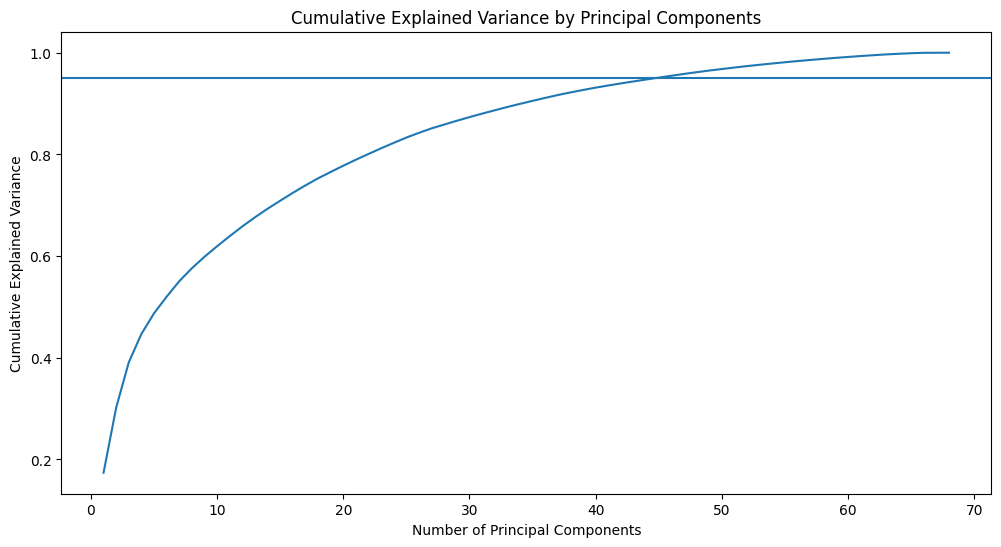

In [ ]:
# Investigate the variance accounted for by each principal component.

# used as reference:  https://stackoverflow.com/questions/53802098/how-to-choose-the-number-of-components-pca-scikitliear#53802415

# explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# cumulative sum of explained variance ratio
cumsum_explained_variance = np.cumsum(explained_variance_ratio)

# plot the explained variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumsum_explained_variance) + 1), cumsum_explained_variance)
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95)
plt.show()

In [ ]:
# looking at the intercept in the plot above, at 95%, choosing 45 components
n_components_chosen = 45

pca_final = PCA(n_components=n_components_chosen)
azdias_pca_final = pca_final.fit_transform(azdias_scaled_df)

print(f'Final PCA transformed data shape with {n_components_chosen} components: {azdias_pca_final.shape}')

Final PCA transformed data shape with 45 components: (780153, 45)


### Discussion 2.2: Perform Dimensionality Reduction

In section 2.2, Principal Component Analysis (PCA) was applied to the scaled data to reduce its dimensionality. Initially, PCA was performed with all components to understand the variance explained by each. Then the cumulative explained variance ratio was plotted against the number of principal components. This plot helped to identify the optimal number of components.

Looking at the graph, a cumulative explained variance of around 95% was achieved with approximately 45 principal components. Therefore, 45 principal components were retained for the subsequent clustering analysis. This number captures a substantial amount of the dataset's variance while significantly reducing the feature space from the original 68 features.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
def pca_component_weights(pca_object, component_number, feature_names, n_display=10):

    # dataFrame to sort
    loadings_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': pca_object.components_[component_number]
    })

    # sort by weight
    sorted_loadings = loadings_df.sort_values(by='Weight', ascending=False)

    # printing the top positive and negative n_display components
    print(f'\nPrincipal Component {component_number + 1}:\n')

    print(f'Top {n_display} positive features:')
    print(sorted_loadings.head(n_display).to_string(index=n_display))

    print(f'\nTop {n_display} negative features:')
    print(sorted_loadings.tail(n_display).to_string(index=n_display))

    return sorted_loadings

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Call the helper function for the first principal component (component_number = 0)
pca_weights_first = pca_component_weights(pca_final, 0, azdias_cleaned_final_df.columns)



Principal Component 1:

Top 10 positive features:
                Feature   Weight
50           MOBI_REGIO 0.236078
54           PLZ8_ANTG1 0.223795
40          KBA05_ANTG1 0.219205
44            KBA05_GBZ 0.211722
2     FINANZ_MINIMALIST 0.200020
36          KONSUMNAEHE 0.166747
60             PLZ8_GBZ 0.166718
47           INNENSTADT 0.163287
10  LP_LEBENSPHASE_FEIN 0.144412
11  LP_LEBENSPHASE_GROB 0.129935

Top 10 negative features:
                   Feature    Weight
43             KBA05_ANTG4 -0.150202
55              PLZ8_ANTG2 -0.152170
7         FINANZ_HAUSBAUER -0.163899
46                EWDICHTE -0.194501
62             ORTSGR_KLS9 -0.196771
31      HH_EINKOMMEN_SCORE -0.197238
66  CAMEO_INTL_2015_WEALTH -0.201252
58             PLZ8_BAUMAX -0.213910
57              PLZ8_ANTG4 -0.218496
56              PLZ8_ANTG3 -0.224274


In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights_second = pca_component_weights(pca_final, 1, azdias_cleaned_final_df.columns)


Principal Component 2:

Top 10 positive features:
                 Feature   Weight
0   ALTERSKATEGORIE_GROB 0.271601
4       FINANZ_VORSORGER 0.244014
19             SEMIO_ERL 0.235095
18            SEMIO_LUST 0.189725
12        RETOURTYP_BK_S 0.164928
32        W_KEIT_KIND_HH 0.116267
22            SEMIO_KRIT 0.112967
24            SEMIO_KAEM 0.103081
2      FINANZ_MINIMALIST 0.094611
7       FINANZ_HAUSBAUER 0.093786

Top 10 negative features:
                         Feature    Weight
21                     SEMIO_RAT -0.181955
14                     SEMIO_FAM -0.188381
5                 FINANZ_ANLEGER -0.213465
20                    SEMIO_KULT -0.224246
6          FINANZ_UNAUFFAELLIGER -0.233244
26                   SEMIO_TRADV -0.239299
25                 SEMIO_PFLICHT -0.240719
3                  FINANZ_SPARER -0.251207
64  PRAEGENDE_JUGENDJAHRE_DECADE -0.260929
15                     SEMIO_REL -0.265165


In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights_third = pca_component_weights(pca_final, 2, azdias_cleaned_final_df.columns)


Principal Component 3:

Top 10 positive features:
                         Feature   Weight
1                      ANREDE_KZ 0.369528
24                    SEMIO_KAEM 0.338568
23                     SEMIO_DOM 0.313424
22                    SEMIO_KRIT 0.275564
21                     SEMIO_RAT 0.215949
5                 FINANZ_ANLEGER 0.188155
19                     SEMIO_ERL 0.176941
3                  FINANZ_SPARER 0.105237
64  PRAEGENDE_JUGENDJAHRE_DECADE 0.104915
6          FINANZ_UNAUFFAELLIGER 0.096238

Top 10 negative features:
                 Feature    Weight
15             SEMIO_REL -0.071160
0   ALTERSKATEGORIE_GROB -0.077026
32        W_KEIT_KIND_HH -0.085775
4       FINANZ_VORSORGER -0.098846
12        RETOURTYP_BK_S -0.106188
2      FINANZ_MINIMALIST -0.161285
20            SEMIO_KULT -0.235167
14             SEMIO_FAM -0.250310
13             SEMIO_SOZ -0.263614
17            SEMIO_VERT -0.347586


### Discussion 2.3: Interpret Principal Components

### Principal Component One

#### Top Positive Features

- MOBI_REGIO - Movement Patterns
- PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1 - Number of 1-2 family houses in the microcell

#### Top Negative Features

- PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region
- PLZ8_BAUMAX - Most common building type within the PLZ8 region

#### The first principal component emphasizes features related to the number of family houses

### Principal Component Two

#### Top Positive Features

- ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
- FINANZ_VORSORGER - Financial Topology: be prepared
- SEMIO_ERL - Personality Type:  event oriented

#### Top Negative Features
- SEMIO_REL - Personality Type - Religious
- PRAEGENDE_JUGENDJAHRE_DECADE - Generation by decade
- FINANZ_SPARER - Financial Type - Money sparer

#### The second principal component emphasizes features related to age and financial saving

### Principal Component Three

#### Top Positive Features

- ANREDE_KZ - Gender
- SEMIO_KAEM - Personality Type:  Combative Attitude
- SEMIO_DOM - Personality Type:  Dominant Minded

#### Top Negative Features

- SEMIO_VERT - Personality Type:  Dreamful
- SEMIO_SOZ - Personality Type:  Socially minded
- SEMIO_FAM - Personality Type:  Family minded

#### The third principal component emphasizes featues related to personality type


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...

scores = []
clusters_range = list(range(2, 31, 2))

# run k-means clustering on the data
for k in clusters_range:

    # initialize a KMeans object
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)

    # fit the KMeans model
    kmeans.fit(azdias_pca_final)

    # append inertia_ attribute to the scores list
    scores.append(kmeans.inertia_)


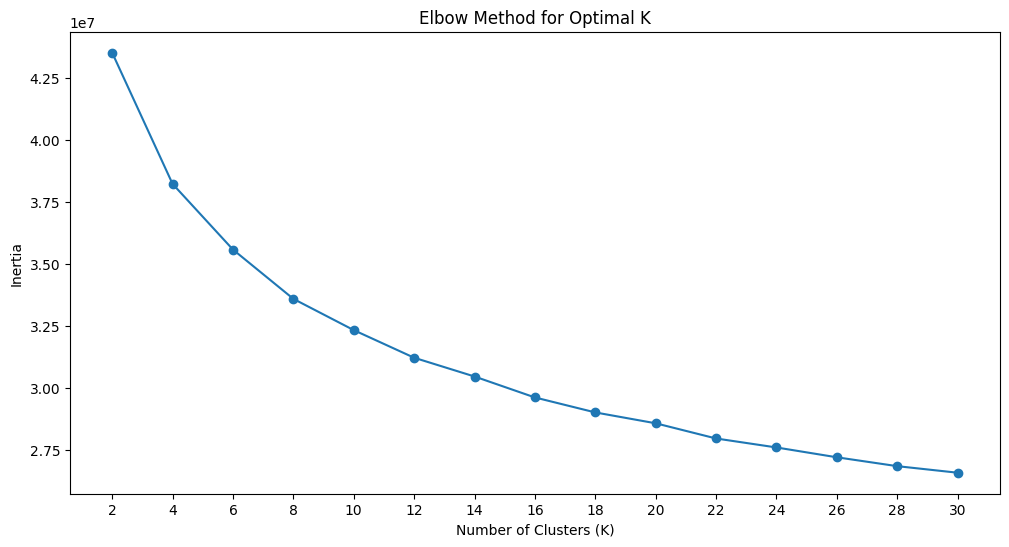

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(12, 6))
plt.plot(clusters_range, scores, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(clusters_range)
plt.show()

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# looking at the graph, the elbow point seems to lie around 12
k_final = 12
kmeans_final = KMeans(n_clusters=k_final, random_state=0)

# fit the model
kmeans_final.fit(azdias_pca_final)

# cluster predictions for the general population
azdias_clusters = kmeans_final.predict(azdias_pca_final)

### Discussion 3.1: Apply Clustering to General Population

In section 3.1, k-means clustering was applied to the PCA-transformed data to segment the general population. To determine the optimal number of clusters (k), the elbow method was used. KMeans was ran for a range of cluster counts (from 2 to 30, with steps of 2) and the inertia was calculated (sum of squared distances of samples to their closest cluster center) for each k.

Plotting the inertia against the number of clusters showed a curve with a sharp decrease in inertia initially, followed by a more gradual decline. The 'elbow point' in this curve indicates the value of k where the rate of decrease significantly slows down, suggesting an optimal balance between the number of clusters and the reduction in inertia. Looking at the plot, the elbow point appeared to be around 12 clusters. Therefore, the population was segmented into 12 clusters for further analysis. A final k-means model was then refitted with n_clusters=12 to obtain the cluster assignments for the general demographics data.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
display(customers.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [ ]:
customers_cleaned_final_df = clean_data(customers)

print('Shape of the cleaned Customer DataFrame:', customers_cleaned_final_df.shape)
display(customers_cleaned_final_df.head())

Shape of the cleaned Customer DataFrame: (139068, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,50.0,1.0,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,13.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,50.0,1.0,3,4
3,4.0,1,5,1,5,2,1,2,0,2.0,NaN,NaN,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,0,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,40.0,0.0,2,4
4,3.0,1,3,1,4,4,5,2,0,3.0,31.0,10.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,3.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,70.0,0.0,4,1
5,3.0,1,5,1,5,1,2,3,1,3.0,17.0,5.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,50.0,1.0,3,4


In [ ]:
print('Missing values in customers_cleaned_final_df before imputation:')
print(customers_cleaned_final_df.isnull().sum().sum())

# apply imputation to customers_cleaned_final_df using the pre-fitted imputer
customers_imputed = imputer.transform(customers_cleaned_final_df)

# convert the numpy array back to a pandas DataFrame
customers_cleaned_final_df = pd.DataFrame(customers_imputed, columns=customers_cleaned_final_df.columns)

print('Missing values in customers_cleaned_final_df after imputation:')
print(customers_cleaned_final_df.isnull().sum().sum())

print('\nShape of Customer DataFrame after imputation:', customers_cleaned_final_df.shape)
display(customers_cleaned_final_df.head())

Missing values in customers_cleaned_final_df before imputation:
90620
Missing values in customers_cleaned_final_df after imputation:
0

Shape of Customer DataFrame after imputation: (139068, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,20.000000,5.000000,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,5.0,1992.0,0.0,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,50.0,1.0,1.0,3.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,13.000000,3.000000,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,1.0,1992.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,50.0,1.0,3.0,4.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,16.286873,4.942992,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,4.0,4.175552,9.0,8.442023,0.041065,2.0,1992.0,0.0,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,40.0,0.0,2.0,4.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,31.000000,10.000000,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,4.0,0.0,6.0,2.000000,9.0,7.000000,0.000000,1.0,1992.0,0.0,3.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,70.0,0.0,4.0,1.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,17.000000,5.000000,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,1.0,6.000000,9.0,1.000000,0.000000,2.0,1992.0,0.0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0,50.0,1.0,3.0,4.0


In [ ]:
customers_scaled = scaler.transform(customers_cleaned_final_df)

customers_scaled_df = pd.DataFrame(customers_scaled, columns=customers_cleaned_final_df.columns)

print('Shape of scaled Customer DataFrame:', customers_scaled_df.shape)
display(customers_scaled_df.head())

Shape of scaled Customer DataFrame: (139068, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.181706,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.817895,1.882535,-1.630686,3.124359e-01,0.015637,1.071711,0.949272,0.466601,-1.042017,1.113214,0.894941,1.259316,-0.889553,-0.072196,-1.744686,-0.878074,-1.954380,-1.762374,-1.167508,-1.545108,-0.091987,-1.069695,0.229631,-0.060808,-2.230685,1.067492e+00,0.553949,-4.744157e-01,-0.126267,1.282137,-0.391262,-0.518769,1.525498,0.365708,0.599160,-0.626328,-0.48661,0.643828,-0.524640,-1.135077,-0.266435,0.287835,-1.826838,0.73721,0.181428,-1.963856,1.721834,0.772827,0.215548,-0.607662,-0.96719,-0.650770,1.432164,1.464792,-2.186565,-1.439894,-1.533367,-1.621097,1.873182,-1.555547,0.087097
1,1.181706,0.958395,1.414618,-1.151087,1.133828,-1.247812,0.980071,0.611953,1.882535,-0.276116,-2.765694e-01,-0.532955,1.071711,-1.110013,-1.105506,-1.565568,-0.454614,-0.653124,1.259316,1.299072,-1.605199,-1.140237,1.408802,0.239454,0.911769,-0.098107,-1.545108,-0.091987,0.978131,-0.633119,-0.060808,-2.230685,1.067492e+00,0.553949,-4.744157e-01,-0.126267,-1.299636,-0.391262,-0.518769,-1.071649,0.365708,0.599160,-0.626328,-0.48661,-0.120483,1.305809,0.029427,-1.744543,-0.796819,0.291010,0.02614,-1.107775,1.426467,-0.549476,-0.261115,0.215548,1.429744,0.41488,0.726008,-0.632762,-1.247980,-0.175058,-0.133526,-0.058279,-1.621097,1.873182,-0.187611,0.760774
2,1.181706,-1.043411,1.414618,-1.151087,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,-5.978763e-16,0.000000,-0.304752,0.949272,0.466601,-0.518465,0.067996,1.410963,0.307194,-0.889553,-0.072196,-0.535788,-0.878074,-0.857463,-0.692717,-0.632808,0.156547,-0.091987,-1.069695,-1.495869,-0.060808,-0.285204,1.039353e-15,0.553949,2.264792e-16,0.000000,-0.654193,-0.391262,-0.518769,1.525498,1.089118,-1.032570,-0.626328,-0.48661,0.643828,1.305809,-1.717329,1.211674,0.287835,0.291010,0.73721,-0.463173,0.861414,0.402818,0.772827,-0.876677,-0.607662,-0.96719,-0.650770,-0.632762,0.560535,-2.186565,-1.004438,-1.533367,-2.318741,-0.552603,-0.871579,0.760774
3,0.198771,-1.043411,-0.036761,-1.151087,0.407468,0.788502,1.697599,-0.817895,-0.531199,1.078455,1.238016e+00,1.387118,1.071711,-0.080370,0.466601,0.005086,1.113214,0.378919,0.783255,-0.342397,0.438806,0.673109,-0.878074,0.239454,-1.227545,0.436593,0.156547,-0.091987,0.978131,1.955131,-0.060808,1.011783,-1.272924e+00,0.553949,-9.192636e-02,-0.126267,-1.299636,-0.391262,-0.518769,-0.552220,-1.081112,1.415025,1.377874,-0.48661,-0.120483,-0.524640,0.029427,-0.266435,-0.796819,1.349933,0.02614,1.470631,1.426467,-0.312882,-0.261115,1.307774,0.411041,0.41488,0.037619,-0.632762,-0.343723,-0.175058,-0.133526,-1.533367,-0.225811,-0.552603,0.496357,-1.260258
4,0.198771,-1.043411,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.102971,1.882535,1.078455,6.000508e-02,0.015637,-0.304752,0.949272,-0.057434,0.005086,-1.499833,1.410963,0.783255,-0.342397,0.949807,-1.140237,0.265364,0.239454,-0.692717,-0.632808,0.156547,-0.091987,0.978131,0.229631,-0.060808,-2.230685,1.067492e+00,0.553949,-4.744157e-01,-0.126267,-0.654193,-0.391262,-0.518769,-1.591079,0.365708,0.599160,0.375773,-0.48661,-0.12048

In [ ]:
customers_pca = pca_final.transform(customers_scaled_df)

print(f'Shape of PCA transformed Customer data: {customers_pca.shape}')

Shape of PCA transformed Customer data: (139068, 45)


In [ ]:
customers_clusters = kmeans_final.predict(customers_pca)

print(f'Shape of customer cluster assignments: {customers_clusters.shape}')

Shape of customer cluster assignments: (139068,)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [ ]:
general_population_proportions = pd.Series(azdias_clusters).value_counts(normalize=True).sort_index()

print('General Population Cluster Proportions:')
display(general_population_proportions)

General Population Cluster Proportions:


,proportion
0,0.074397
1,0.082006
2,0.102773
3,0.105361
4,0.100302
5,0.047729
6,0.072508
7,0.088694
8,0.075715
9,0.071626


In [ ]:
customer_proportions = pd.Series(customers_clusters).value_counts(normalize=True).sort_index()

print('Customer Cluster Proportions:')
display(customer_proportions)

Customer Cluster Proportions:


,proportion
0,0.338748
1,0.066076
2,0.097521
3,0.014137
4,0.009463
5,0.031733
6,0.052773
7,0.065709
8,0.017610
9,0.119956


Cluster Proportions and Ratio:


,General Population,Customer Data,Ratio (Customer/General)
0,0.074397,0.338748,4.553251
1,0.082006,0.066076,0.805744
2,0.102773,0.097521,0.948890
3,0.105361,0.014137,0.134176
4,0.100302,0.009463,0.094345
5,0.047729,0.031733,0.664850
6,0.072508,0.052773,0.727824
7,0.088694,0.065709,0.740848
8,0.075715,0.017610,0.232585
9,0.071626,0.119956,1.674758


<Figure size 1200x700 with 0 Axes>

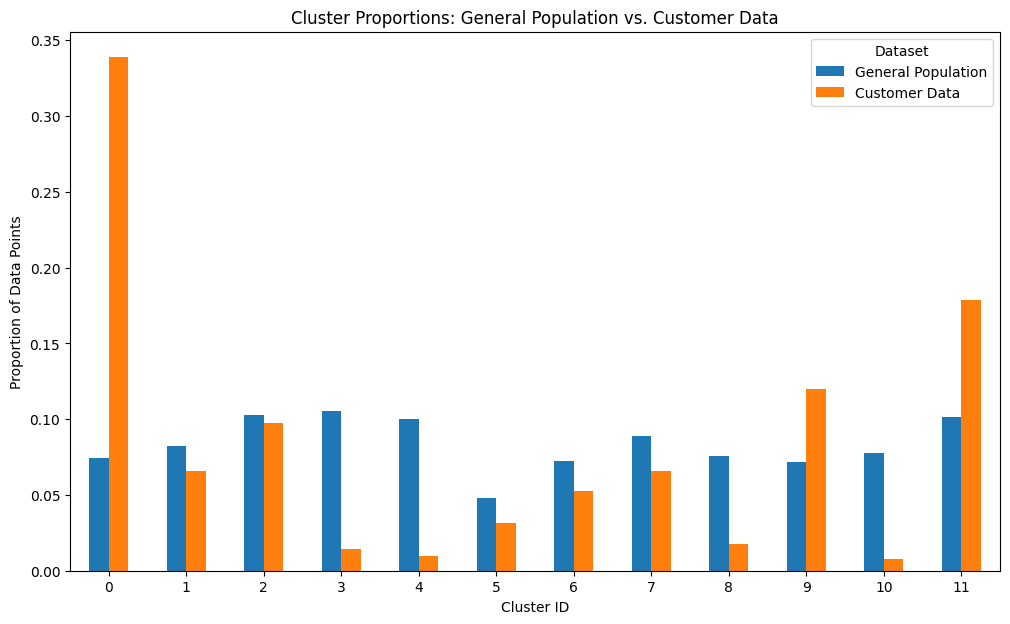

In [ ]:
cluster_comparison_df = pd.DataFrame({
    'General Population': general_population_proportions,
    'Customer Data': customer_proportions
})

cluster_comparison_df['Ratio (Customer/General)'] = cluster_comparison_df['Customer Data'] / cluster_comparison_df['General Population']

print('Cluster Proportions and Ratio:')
display(cluster_comparison_df)

plt.figure(figsize=(12, 7));
cluster_comparison_df[['General Population', 'Customer Data']].plot(kind='bar', figsize=(12, 7))
plt.title('Cluster Proportions: General Population vs. Customer Data')
plt.xlabel('Cluster ID')
plt.ylabel('Proportion of Data Points')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [ ]:
# most overrepresented cluster
over_cluster = cluster_comparison_df['Ratio (Customer/General)'].idxmax().item()

# most underrepresented cluster
under_cluster = cluster_comparison_df['Ratio (Customer/General)'].idxmin().item()

print('Most Overrepresented Cluster:', over_cluster)
print('Most Underrepresented Cluster:', under_cluster)

Most Overrepresented Cluster: 0
Most Underrepresented Cluster: 4


In [ ]:
# scaled clusters

cluster_centers_scaled = pca_final.inverse_transform(
    kmeans_final.cluster_centers_
)

cluster_centers_scaled_df = pd.DataFrame(
    cluster_centers_scaled,
    columns=azdias_cleaned_final_df.columns
)

In [ ]:
# top influential features in overrepresented cluster

top_scaled_over = (
    cluster_centers_scaled_df.loc[over_cluster]
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

top_scaled_over

,0
GREEN_AVANTGARDE,1.794753
PRAEGENDE_JUGENDJAHRE_MOVEMENT,1.785463
HH_EINKOMMEN_SCORE,1.323859
FINANZ_MINIMALIST,1.276410
SEMIO_VERT,1.049271
ANREDE_KZ,0.965396
SEMIO_KAEM,0.926575
KBA05_ANTG1,0.892388
FINANZ_ANLEGER,0.879061
FINANZ_HAUSBAUER,0.864173


In [ ]:
# top influential features in underrepresented cluster

top_scaled_under = (
    cluster_centers_scaled_df.loc[under_cluster]
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

top_scaled_under


,4
SEMIO_RAT,1.440644
FINANZ_MINIMALIST,1.349934
SEMIO_PFLICHT,1.115384
ALTERSKATEGORIE_GROB,1.104305
SEMIO_TRADV,1.097739
FINANZ_SPARER,1.039954
SEMIO_VERT,1.002056
SEMIO_KAEM,0.991266
ANREDE_KZ,0.951391
SEMIO_DOM,0.927010


In [ ]:
# original clusters

cluster_centers_original = scaler.inverse_transform(
    cluster_centers_scaled_df
)

cluster_centers_original_df = pd.DataFrame(
    cluster_centers_original,
    columns=azdias_cleaned_final_df.columns
)


In [ ]:
# show original values for influential features in most overrepresented cluster

comparison_over = pd.DataFrame({
    'Original Value': cluster_centers_original_df.loc[over_cluster, top_scaled_over.index],
    'Population Mean': azdias_cleaned_final_df[top_scaled_over.index].mean(),
    'Scaled Strength': cluster_centers_scaled_df.loc[over_cluster, top_scaled_over.index]
}).sort_values('Scaled Strength', key=lambda x: x.abs(), ascending=False)

comparison_over


,Original Value,Population Mean,Scaled Strength
GREEN_AVANTGARDE,0.963632,0.220073,1.794753
PRAEGENDE_JUGENDJAHRE_MOVEMENT,0.963839,0.227804,1.785463
HH_EINKOMMEN_SCORE,2.398358,4.439795,-1.323859
FINANZ_MINIMALIST,4.809550,3.050657,1.276410
SEMIO_VERT,6.299077,4.265691,1.049271
ANREDE_KZ,1.038972,1.521235,-0.965396
SEMIO_KAEM,2.562743,4.295213,-0.926575
KBA05_ANTG1,2.728052,1.494466,0.892388
FINANZ_ANLEGER,1.543262,2.838339,-0.879061
FINANZ_HAUSBAUER,1.935269,3.144031,-0.864173


In [ ]:
# show original values for influential features in most underrepresented cluster

comparison_under = pd.DataFrame({
    'Original Value': cluster_centers_original_df.loc[under_cluster, top_scaled_under.index],
    'Population Mean': azdias_cleaned_final_df[top_scaled_under.index].mean(),
    'Scaled Strength': cluster_centers_scaled_df.loc[under_cluster, top_scaled_under.index]
}).sort_values('Scaled Strength', key=lambda x: x.abs(), ascending=False)

comparison_under


,Original Value,Population Mean,Scaled Strength
SEMIO_RAT,6.269809,3.886408,1.440644
FINANZ_MINIMALIST,1.190448,3.050657,-1.349934
SEMIO_PFLICHT,6.269478,4.183481,1.115384
ALTERSKATEGORIE_GROB,1.674301,2.797778,-1.104305
SEMIO_TRADV,5.659312,3.724009,1.097739
FINANZ_SPARER,4.257852,2.711548,1.039954
SEMIO_VERT,2.323803,4.265691,-1.002056
SEMIO_KAEM,6.148640,4.295213,0.991266
ANREDE_KZ,1.996501,1.521235,0.951391
SEMIO_DOM,6.253615,4.563405,0.927010


### Discussion 3.3: Compare Customer Data to Demographics Data

#### Most Overrepresented Cluster in Customer Data

Most influential features:

- GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth (positive influence, higher score means more avantgarde)
- PRAEGENDE_JUGENDJAHRE_MOVEMENT - Dominating movement of person's youth avantgarde vs. mainstream (positive influence, higher score means more avantgarde)
- HH_EINKOMMEN_SCORE - Estimated household net income (negative influence, higher score means lower income)

The customer population appears to be more avantgarde, and higher income than the general population.

#### Most Underrepresented Cluster in Customer Data

Most influential features:

- SEMIO_RAT - Personality Type: rational (positive influence, higher score means lower rational affinity)
- FINANZ_MINIMALIST - low financial interest (negative influence, higher score means lower low financial interest)
- SEMIO_PFLICHT - Personality Type: dutiful (positive influence, higher score means lower dutiful affinity)

The general population appears to be less rational and dutiful, and less interested in financial issues than the customer population.